<a href="https://colab.research.google.com/github/Dharmendra04/XAI---Grad-Cam-for-Xception-pretrained-model/blob/main/XAI_Analysis_Using_Grad_Cam_and_Lime_for_Braintumor_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the test images and unzipping

In [ ]:

#https://drive.google.com/file/d/1hLDzt0uVR1nxxXXyV3l8tzJKqD4J4Ntt/view?usp=share_link
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file from Google Drive
#give the pass code from the get link option by right clicking zip the folder in google drive
file_id = '1hLDzt0uVR1nxxXXyV3l8tzJKqD4J4Ntt'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Grad_Cam_Test.Zip')

# Extract the contents of the zip file
with zipfile.ZipFile('Grad_Cam_Test.Zip', 'r') as zip_ref:
     zip_ref.extractall('/content')

Importing Required packages

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Loading Xception Pretrained Model

In [ ]:
# Load the saved model
loaded_model = keras.models.load_model('/content/drive/MyDrive/Applied Artificial Intelligence/Models_Xception121.h5')

# Print the model summary
print(loaded_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

## *Creating Grad Cam and Heat map function*

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output , self.model.output])#[0.9,0.05,0.05]) 

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32) #cast - changing to new datatype
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])] 
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32") #setting all negative values to zero
        castGrads = tf.cast(grads > 0, "float32") #setting all negative gradients to zero
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]#removing the batch size
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1)) #getting mean row wise and then coloumn wise
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1) #summing through channel axis

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

Preparing the Heat map and output

In [ ]:
#preprocessing the image for a misclassified image
image = cv2.imread('/content/drive/MyDrive/Applied Artificial Intelligence/Glioma_original_2757.png_3ea5f5d7-9372-4721-a228-33a62ec72f04.png')
image = cv2.resize(image, (299, 299))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
preds = loaded_model.predict(image)
sor = sorted(preds[0],reverse =True)
i = np.argmax(preds[0])
print(i) #though this image is Giloma, it is catagorised as Meningioma :1, hence it is a miscalssified image

1/1 [==============================] - 10s 10s/step
1


In [ ]:
for idx in range(len(loaded_model.layers)):
  print(loaded_model.get_layer(index = idx).name)

# all ;layers can be seen from this list

input_1
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sepconv2_

In [ ]:
#using Grad Cam to produce the heatmaps and output
icam = GradCAM(loaded_model, i, 'block14_sepconv2') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (299, 299))

image = cv2.imread('/content/drive/MyDrive/Applied Artificial Intelligence/Glioma_original_2757.png_3ea5f5d7-9372-4721-a228-33a62ec72f04.png')
image = cv2.resize(image, (299, 299))


(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


## Visualising the Image, Heatmaps and Grad Cam Image

Text(0.5, 1.0, 'Superpositioned Image')

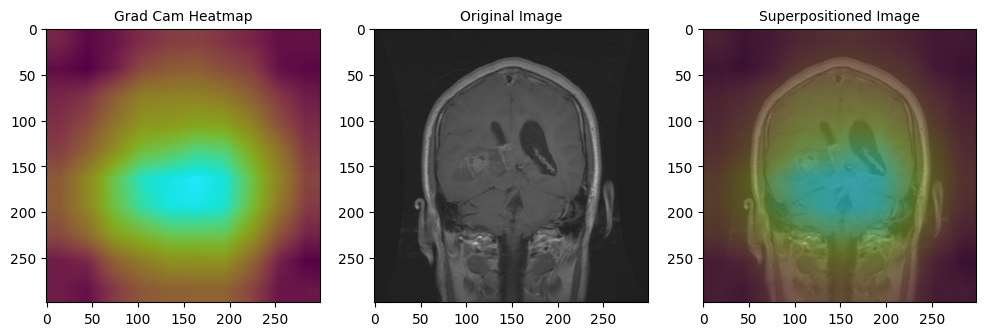

In [ ]:
#plotting the graphs
fig, ax = plt.subplots(1, 3,figsize= (12,10))

ax[0].imshow(heatmap)
ax[0].set_title('Grad Cam Heatmap',fontsize = 10)

ax[1].imshow(image)
ax[1].set_title('Original Image',fontsize = 10)

ax[2].imshow(output)
ax[2].set_title('Superpositioned Image',fontsize = 10)


Creating the Dictionary to store all 36 test images and its Grad Cam images  from Giloma, Meningioma, Pituitary tumor

In [ ]:
#creating a cluster of images to analyse variety of images when needed  

image_path = '/content/Grad_Cam_Test/'

tumor_type = ['Giloma','Meningioma','Pituitary tumor']

#pt is the shortest word used for pitutitary tumor for convinience
#A dictioanry to save the relevant attributes 
Dic = {'heat_map_Giloma':None,'Grad_Cam_Giloma':None, 'Giloma_prediction': None,'Giloma_image':None,
              'heat_map_Meningioma':None,'Grad_Cam_Meningioma':None,'Meningioma_prediction':None,'Meningioma_image':None,
              'heat_map_Pt':None,'Grad_Cam_Pt':None,'Pt_prediction':None,'Pt_image':None,'Ground_Truth_Giloma':None ,'Ground_Truth_Meningioma':None,'Ground_Truth_Pt':None}


for i in tumor_type:
  image_dir = os.path.join(image_path,str(i))
  

  for k in range(1,13):
    open_image = os.path.join(image_dir,str(k)+'.png')

    #preprocessign the image and getting the prediction from model
    image = cv2.imread(open_image)
    image = cv2.resize(image, (299, 299))
    image = image.astype('float32') / 255
    image = np.expand_dims(image, axis=0)
    print(image.shape)
    preds = loaded_model.predict(image) 
    print(preds)
    m = np.argmax(preds[0])
    if m ==0:
      m = 'Prediction:Giloma'
    elif m==1: 
      m = 'Prediction:Meningioma'
    elif m==2:
      m = 'Prediction:Pituitary tumor'

    #Uisng grad cam model and creating heat maps
    icam = GradCAM(loaded_model, m, 'block14_sepconv2') 
    heatmap = icam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (299, 299))
    print(heatmap.shape)

    image = cv2.imread(open_image)
    image = cv2.resize(image, (299, 299))
    

    (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

#adding the relevant attributes to the dictionary 
    if i == 'Giloma':
      if Dic['heat_map_Giloma'] is None:
        Dic['heat_map_Giloma'] = [heatmap]
        Dic['Grad_Cam_Giloma'] = [output]
        Dic['Giloma_prediction'] = [m]
        Dic['Giloma_image'] = [image]
        Dic['Ground_Truth_Giloma'] = ['Giloma']

      else:
        Dic['heat_map_Giloma'].append(heatmap)
        Dic['Grad_Cam_Giloma'].append(output)
        Dic['Giloma_prediction'].append(m)
        Dic['Giloma_image'].append(image)
        Dic['Ground_Truth_Giloma'].append('Giloma')

    elif i == 'Meningioma':
      if Dic['heat_map_Meningioma'] is None:
        Dic['heat_map_Meningioma'] = [heatmap]
        Dic['Grad_Cam_Meningioma'] = [output]
        Dic['Meningioma_prediction'] = [m]
        Dic['Meningioma_image'] = [image]
        Dic['Ground_Truth_Meningioma'] = ['Meningioma']

      else:
        Dic['heat_map_Meningioma'].append(heatmap)
        Dic['Grad_Cam_Meningioma'].append(output)
        Dic['Meningioma_prediction'].append(m)
        Dic['Meningioma_image'].append(image)
        Dic['Ground_Truth_Meningioma'].append('Meningioma')

    elif i == 'Pituitary tumor':
      if Dic['heat_map_Pt'] is None:
        Dic['heat_map_Pt'] = [heatmap]
        Dic['Grad_Cam_Pt'] = [output]
        Dic['Pt_prediction'] = [m]
        Dic['Pt_image'] = [image]
        Dic['Ground_Truth_Pt'] = ['Pituitary tumor']

      else:
        Dic['heat_map_Pt'].append(heatmap)
        Dic['Grad_Cam_Pt'].append(output)
        Dic['Pt_prediction'].append(m)
        Dic['Pt_image'].append(image)
        Dic['Ground_Truth_Pt'].append('Pituitary tumor')
      
    

(1, 299, 299, 3)
1/1 [==============================] - 0s 22ms/step
[[0.9745497  0.01134122 0.01410901]]
(299, 299)
(1, 299, 299, 3)
1/1 [==============================] - 0s 23ms/step
[[9.9587268e-01 3.7907774e-03 3.3660518e-04]]
(299, 299)
(1, 299, 299, 3)
1/1 [==============================] - 0s 29ms/step
[[0.8882087  0.06888059 0.04291066]]
(299, 299)
(1, 299, 299, 3)
1/1 [==============================] - 0s 22ms/step
[[9.9593073e-01 3.9040095e-03 1.6524445e-04]]
(299, 299)
(1, 299, 299, 3)
1/1 [==============================] - 0s 25ms/step
[[0.9895085  0.00708109 0.00341042]]
(299, 299)
(1, 299, 299, 3)
1/1 [==============================] - 0s 23ms/step
[[0.88058746 0.0676406  0.05177202]]
(299, 299)
(1, 299, 299, 3)
1/1 [==============================] - 0s 24ms/step
[[0.94437784 0.04977206 0.00585015]]
(299, 299)
(1, 299, 299, 3)
1/1 [==============================] - 0s 36ms/step
[[0.8844008  0.07912049 0.0364787 ]]
(299, 299)
(1, 299, 299, 3)
1/1 [========================

Text(0, -0.2, 'Ground Truth:Pituitary tumor   Prediction:Pituitary tumor')

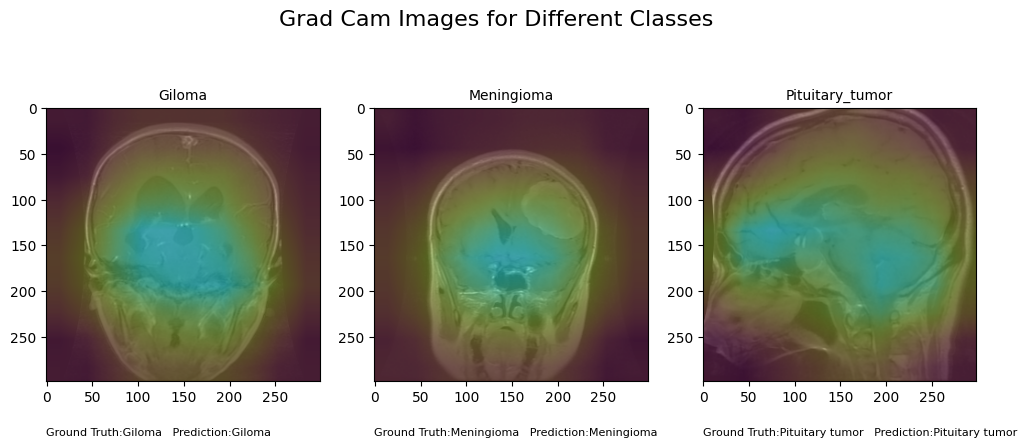

In [ ]:
#plotting the different types of images using Grad Cam
fig, ax = plt.subplots(1, 3,figsize =(12,10))
fig.suptitle("Grad Cam Images for Different Classes", fontsize=16,y=0.73)

ax[0].imshow(Dic['Grad_Cam_Giloma'][11])
ax[0].set_title('Giloma',fontsize = 10)
ax[0].text(-0, -0.2,f"Ground Truth:{Dic['Ground_Truth_Giloma'][2]}   {Dic['Giloma_prediction'][2]}", size=8, ha='left',transform=ax[0].transAxes)


ax[1].imshow(Dic['Grad_Cam_Meningioma'][11])
ax[1].set_title('Meningioma',fontsize = 10)
ax[0].text(-0, -0.2, f"Ground Truth:{Dic['Ground_Truth_Meningioma'][2]}   {Dic['Meningioma_prediction'][2]}", size=8, ha='left',transform=ax[1].transAxes)

ax[2].imshow(Dic['Grad_Cam_Pt'][2])
ax[2].set_title('Pituitary_tumor',fontsize = 10)
ax[2].text(-0, -0.2, f"Ground Truth:{Dic['Ground_Truth_Pt'][11]}   {Dic['Pt_prediction'][11]}", size=8, ha='left',transform=ax[2].transAxes)

# Creating layer wise visualisation for Incorrect prediction

In [ ]:
#creating a list of layers in the model
layer_list = ['block14_sepconv2','block14_sepconv1','block13_sepconv2','block13_sepconv1','block2_sepconv2','block2_sepconv1',
              'block1_conv2','block1_conv1']

#A dictioanry to save the relevant attributes 
Dic1 = {'heatmap':None,
        'image':None,
        'pred':None,
        'grad_cam':None,
        'pred_prob':None}

#you can change this name with  Dic['Giloma_image'][3] , you can use any number beween 0 and 12, Change Giloma, with Meningioma or Pt
image = cv2.imread('/content/drive/MyDrive/Applied Artificial Intelligence/Glioma_original_2757.png_3ea5f5d7-9372-4721-a228-33a62ec72f04.png')
image = cv2.resize(image, (299, 299))
image = image.astype('float32') / 255

image = np.expand_dims(image, axis=0)
preds = loaded_model.predict(image)
i = np.argmax(preds[0]) #prediction of the model
m = i.copy()
if m ==0:
  m = 'Prediction : Giloma'
elif m==1: 
  m = 'Prediction : Meningioma'
elif m==2:
  m = 'Prediction :Pituitary tumor'



for k in range(8):
  icam = GradCAM(loaded_model, i, layer_list[k]) 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  #you can change this name with  Dic['Giloma_image'][3] , you can use any number beween 0 and 12, Change Giloma, with Meningioma or Pt
  image = cv2.imread('/content/drive/MyDrive/Applied Artificial Intelligence/Glioma_original_2757.png_3ea5f5d7-9372-4721-a228-33a62ec72f04.png')
  image = cv2.resize(image, (299, 299))
    

  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

  if Dic1['heatmap'] is None:
      Dic1['heatmap'] = [heatmap]
      Dic1['grad_cam'] = [output]
      Dic1['pred'] = [m]
      Dic1['image'] = [image]
      Dic1['pred_prob'] = [preds]
        
  else:
        Dic1['heatmap'].append(heatmap)
        Dic1['grad_cam'].append(output)
        Dic1['pred'].append(m)
        Dic1['image'].append(image)
        Dic1['pred_prob'].append([preds])
  image = image[np.newaxis,...]

1/1 [==============================] - 0s 23ms/step


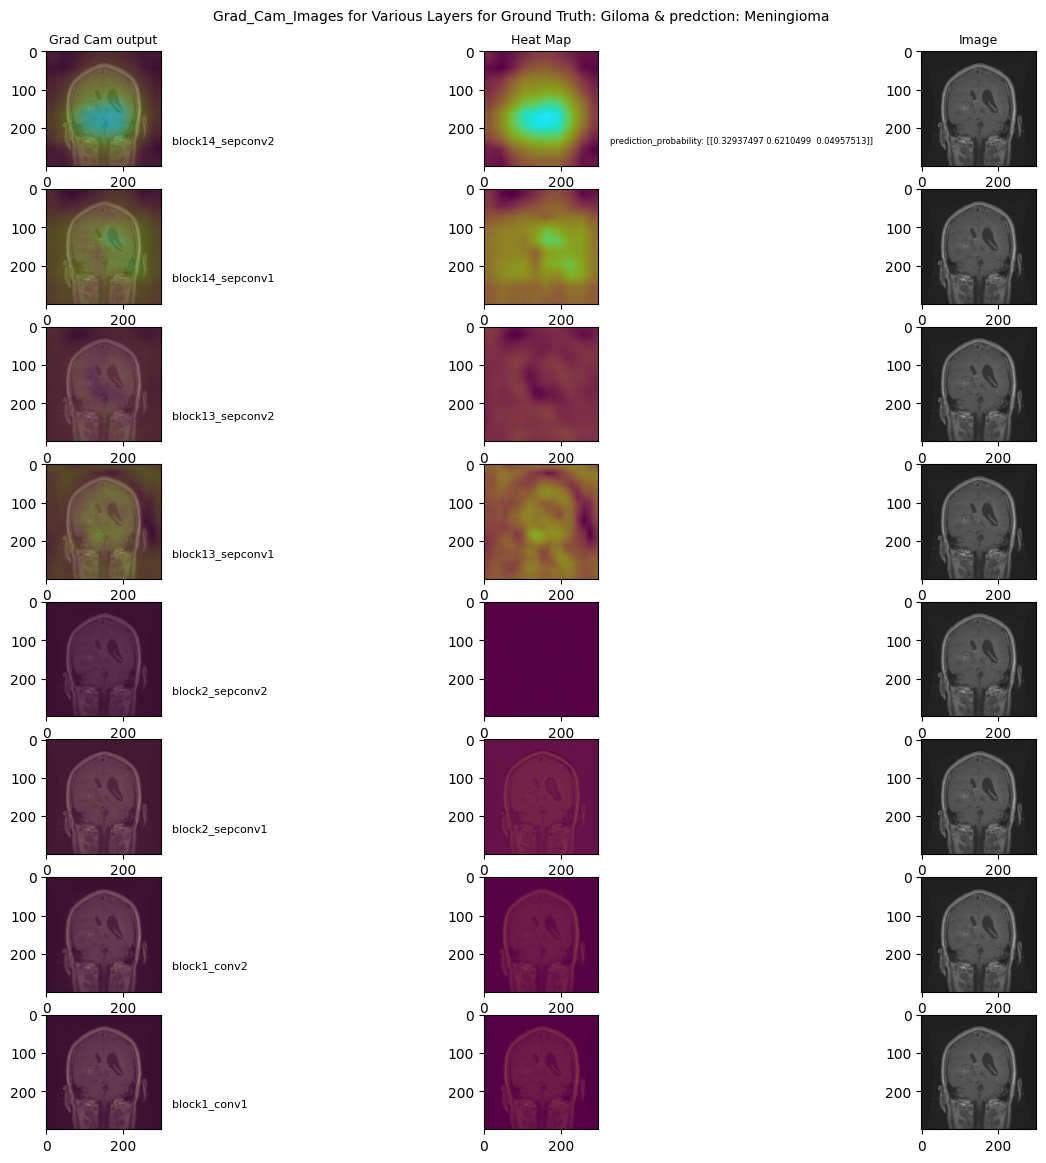

In [ ]:
#plotting the layer by layer visualisation using Grad Cam
fig, ax = plt.subplots(8, 3,figsize =(16,14))
fig.suptitle(f"Grad_Cam_Images for Various Layers for Ground Truth: Giloma & predction: Meningioma", fontsize=10,y=0.91)
for n in range (8):
  if n==0:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].set_title('Grad Cam output',fontsize = 9)
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)

    ax[n,1].imshow(Dic1['heatmap'][n])
    ax[n,1].set_title('Heat Map',fontsize = 9)
    ax[n,1].text(1.1, 0.2, f"prediction_probability: {Dic1['pred_prob'][0]}", size=6, ha='left',transform=ax[n,1].transAxes)

    ax[n,2].imshow(Dic1['image'][n])
    ax[n,2].set_title('Image',fontsize = 9)
  
  else:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)
   
    ax[n,1].imshow(Dic1['heatmap'][n])
   

    ax[n,2].imshow(Dic1['image'][n])

# Creating layer wise visualisation for Correct Giloma prediction

In [ ]:
layer_list = ['block14_sepconv2','block14_sepconv1','block13_sepconv2','block13_sepconv1','block2_sepconv2','block2_sepconv1',
              'block1_conv2','block1_conv1']

Dic1 = {'heatmap':None,
        'image':None,
        'pred':None,
        'grad_cam':None,
        'pred_prob':None}


image = Dic['Giloma_image'][11] 
image = cv2.resize(image, (299, 299))
image = image.astype('float32') / 255

image = np.expand_dims(image, axis=0)
preds = loaded_model.predict(image)
i = np.argmax(preds[0]) #prediction of the model
m = i.copy()
if m ==0:
  m = 'Prediction : Giloma'
elif m==1: 
  m = 'Prediction : Meningioma'
elif m==2:
  m = 'Prediction :Pituitary tumor'



for k in range(8):
  icam = GradCAM(loaded_model, i, layer_list[k]) 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  image = Dic['Giloma_image'][11]
  image = cv2.resize(image, (299, 299))
    

  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

 
  if Dic1['heatmap'] is None:
      Dic1['heatmap'] = [heatmap]
      Dic1['grad_cam'] = [output]
      Dic1['pred'] = [m]
      Dic1['image'] = [image]
      Dic1['pred_prob'] = [preds]
        
  else:
        Dic1['heatmap'].append(heatmap)
        Dic1['grad_cam'].append(output)
        Dic1['pred'].append(m)
        Dic1['image'].append(image)
        Dic1['pred_prob'].append([preds])
  image = image[np.newaxis,...]

  
  




1/1 [==============================] - 0s 33ms/step


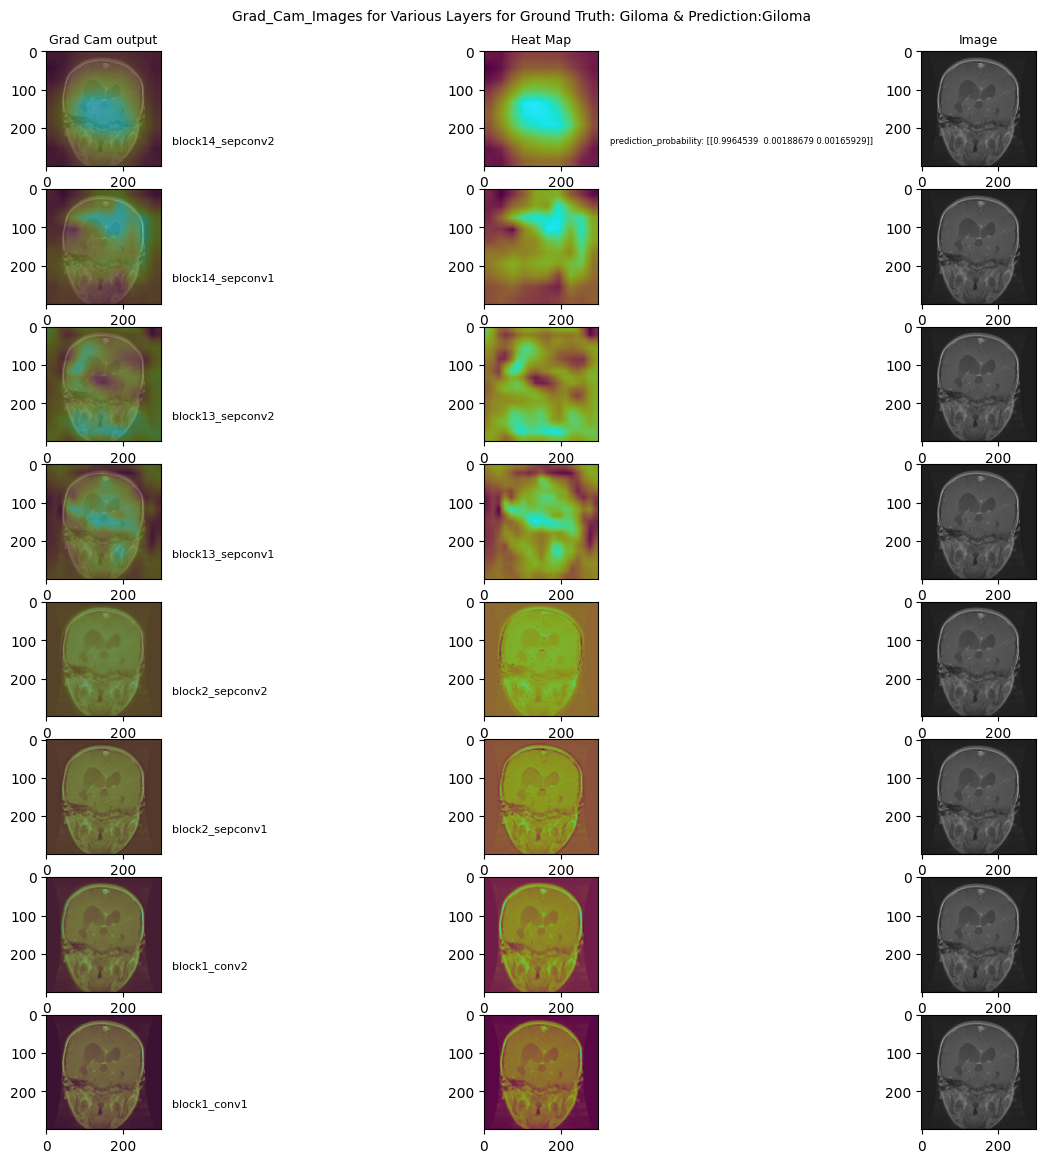

In [ ]:
fig, ax = plt.subplots(8, 3,figsize =(16,14))
fig.suptitle(f"Grad_Cam_Images for Various Layers for Ground Truth: {Dic['Ground_Truth_Giloma'][11]} & {Dic['Giloma_prediction'][11] }", fontsize=10,y=0.91)
for n in range (8):
  if n==0:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].set_title('Grad Cam output',fontsize = 9)
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)

    ax[n,1].imshow(Dic1['heatmap'][n])
    ax[n,1].set_title('Heat Map',fontsize = 9)
    ax[n,1].text(1.1, 0.2, f"prediction_probability: {Dic1['pred_prob'][0]}", size=6, ha='left',transform=ax[n,1].transAxes)

    ax[n,2].imshow(Dic1['image'][n])
    ax[n,2].set_title('Image',fontsize = 9)
  
  else:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)
   
    ax[n,1].imshow(Dic1['heatmap'][n])
   

    ax[n,2].imshow(Dic1['image'][n])
    



  

# Creating layer wise visualisation for Correct Pituitary tumor prediction

In [ ]:
layer_list = ['block14_sepconv2','block14_sepconv1','block13_sepconv2','block13_sepconv1','block2_sepconv2','block2_sepconv1',
              'block1_conv2','block1_conv1']


Dic1 = {'heatmap':None,
        'image':None,
        'pred':None,
        'grad_cam':None,
        'pred_prob':None}


image = Dic['Pt_image'][11] 
image = cv2.resize(image, (299, 299))
image = image.astype('float32') / 255

image = np.expand_dims(image, axis=0)
preds = loaded_model.predict(image)
i = np.argmax(preds[0]) #prediction of the model
m = i.copy()
if m ==0:
  m = 'Prediction : Giloma'
elif m==1: 
  m = 'Prediction : Meningioma'
elif m==2:
  m = 'Prediction :Pituitary tumor'



for k in range(8):
  icam = GradCAM(loaded_model, i, layer_list[k]) 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  image = Dic['Pt_image'][11]
  image = cv2.resize(image, (299, 299))
    

  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


  if Dic1['heatmap'] is None:
      Dic1['heatmap'] = [heatmap]
      Dic1['grad_cam'] = [output]
      Dic1['pred'] = [m]
      Dic1['image'] = [image]
      Dic1['pred_prob'] = [preds]
        
  else:
        Dic1['heatmap'].append(heatmap)
        Dic1['grad_cam'].append(output)
        Dic1['pred'].append(m)
        Dic1['image'].append(image)
        Dic1['pred_prob'].append([preds])
  image = image[np.newaxis,...]

1/1 [==============================] - 0s 25ms/step


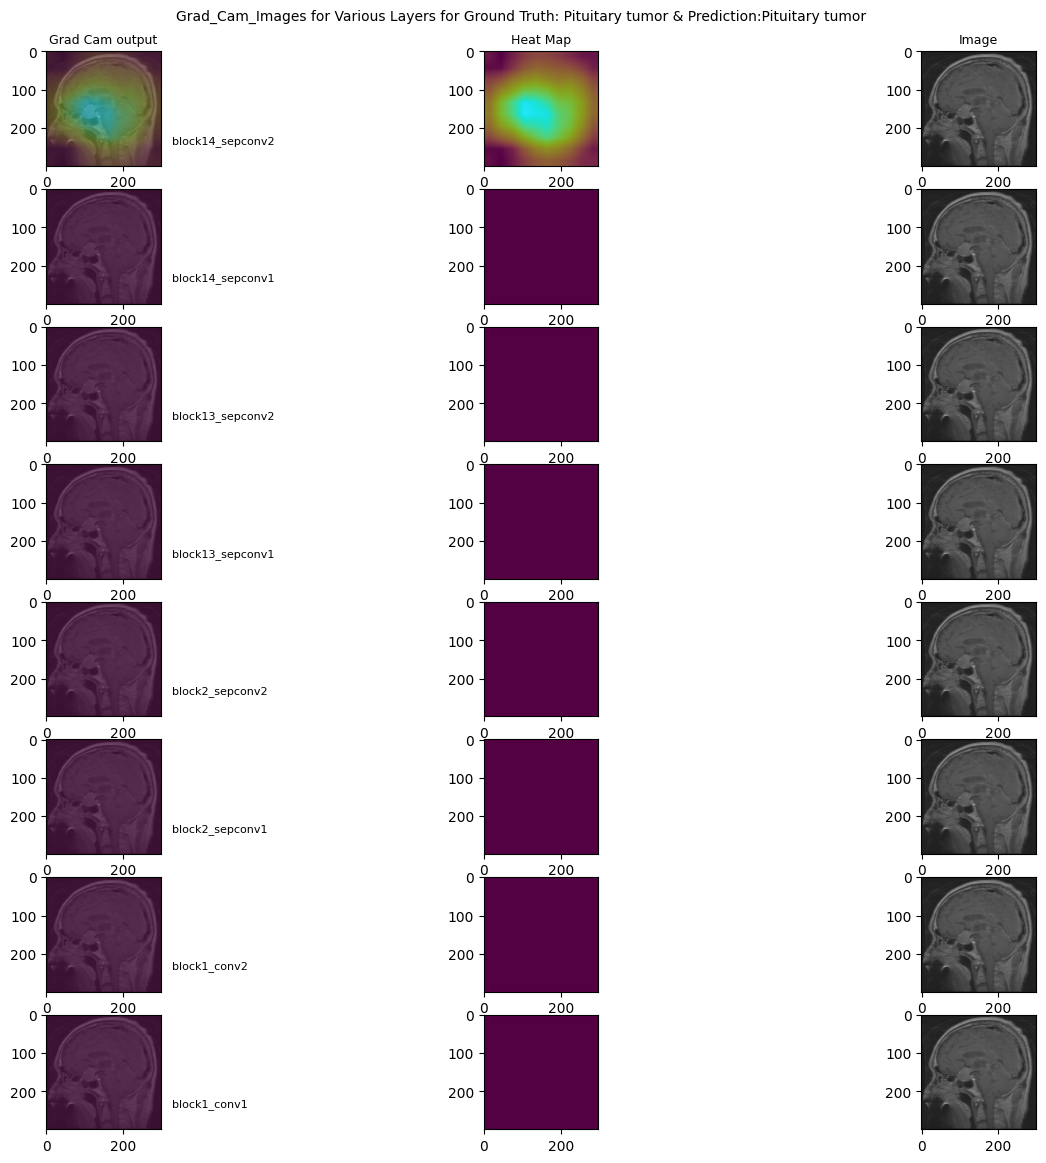

In [ ]:
fig, ax = plt.subplots(8, 3,figsize =(16,14))
fig.suptitle(f"Grad_Cam_Images for Various Layers for Ground Truth: {Dic['Ground_Truth_Pt'][11]} & {Dic['Pt_prediction'][11] }", fontsize=10,y=0.91)
for n in range (8):
  if n==0:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].set_title('Grad Cam output',fontsize = 9)
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)

    ax[n,1].imshow(Dic1['heatmap'][n])
    ax[n,1].set_title('Heat Map',fontsize = 9)
    #ax[n,1].text(1.1, 0.2, f"prediction_probability: {Dic1['pred_prob'][0]}", size=6, ha='left',transform=ax[n,1].transAxes)

    ax[n,2].imshow(Dic1['image'][n])
    ax[n,2].set_title('Image',fontsize = 9)
  
  else:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)
   
    ax[n,1].imshow(Dic1['heatmap'][n])
   

    ax[n,2].imshow(Dic1['image'][n])
    

# Creating layer wise visualisation for Correct Meningioma prediction

In [ ]:
layer_list = ['block14_sepconv2','block14_sepconv1','block13_sepconv2','block13_sepconv1','block2_sepconv2','block2_sepconv1',
              'block1_conv2','block1_conv1']


Dic1 = {'heatmap':None,
        'image':None,
        'pred':None,
        'grad_cam':None,
        'pred_prob':None}


image = Dic['Meningioma_image'][8] 
image = cv2.resize(image, (299, 299))
image = image.astype('float32') / 255

image = np.expand_dims(image, axis=0)
preds = loaded_model.predict(image)
i = np.argmax(preds[0]) #prediction of the model
m = i.copy()
if m ==0:
  m = 'Prediction : Giloma'
elif m==1: 
  m = 'Prediction : Meningioma'
elif m==2:
  m = 'Prediction :Pituitary tumor'



for k in range(8):
  icam = GradCAM(loaded_model, i, layer_list[k]) 
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, (299, 299))

  image = Dic['Meningioma_image'][8]
  image = cv2.resize(image, (299, 299))
    

  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


  if Dic1['heatmap'] is None:
      Dic1['heatmap'] = [heatmap]
      Dic1['grad_cam'] = [output]
      Dic1['pred'] = [m]
      Dic1['image'] = [image]
      Dic1['pred_prob'] = [preds]
        
  else:
        Dic1['heatmap'].append(heatmap)
        Dic1['grad_cam'].append(output)
        Dic1['pred'].append(m)
        Dic1['image'].append(image)
        Dic1['pred_prob'].append([preds])
  image = image[np.newaxis,...]

1/1 [==============================] - 0s 22ms/step


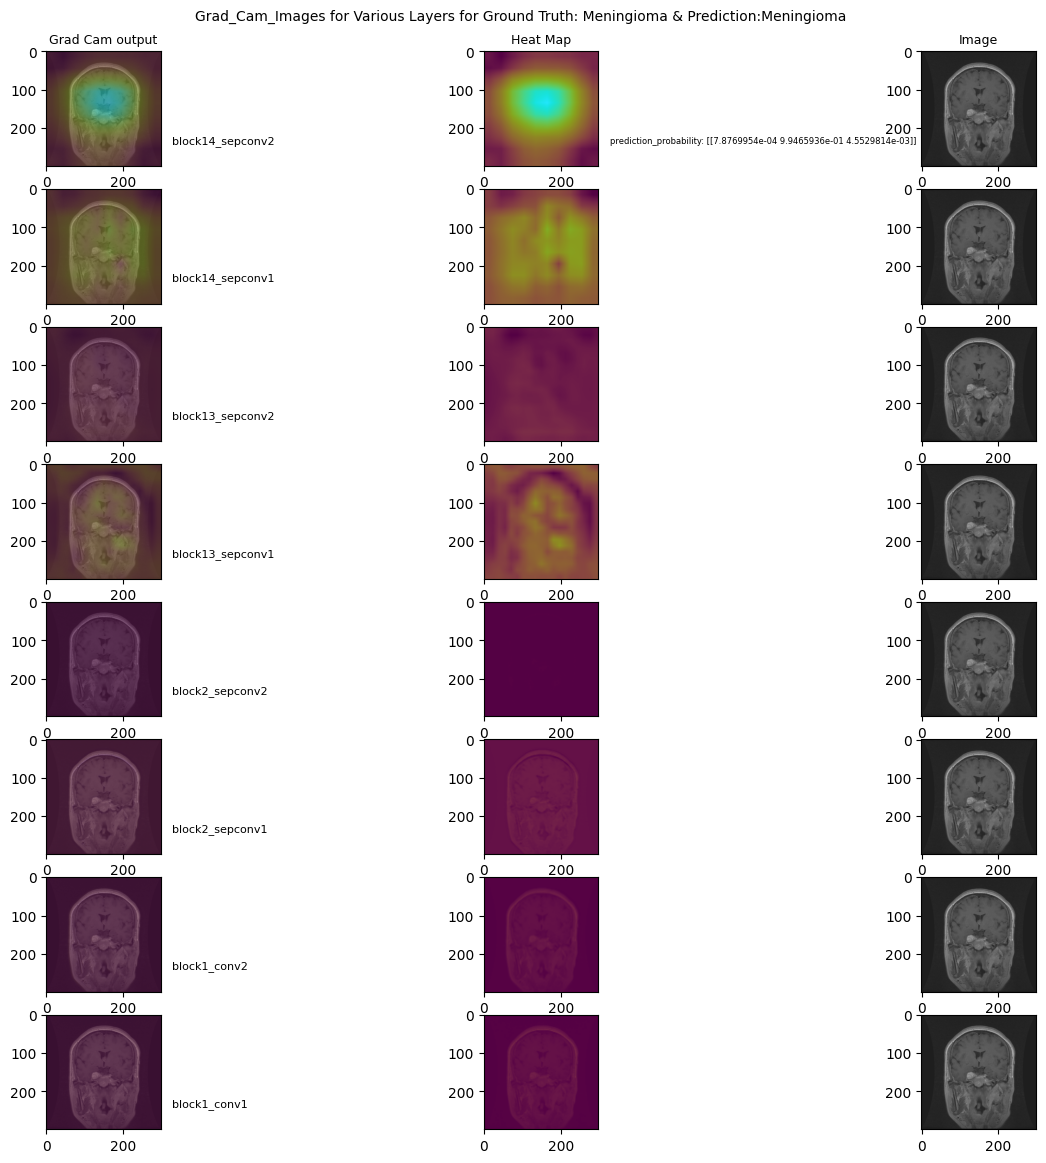

In [ ]:
fig, ax = plt.subplots(8, 3,figsize =(16,14))
fig.suptitle(f"Grad_Cam_Images for Various Layers for Ground Truth: {Dic['Ground_Truth_Meningioma'][8]} & {Dic['Meningioma_prediction'][8] }", fontsize=10,y=0.91)
for n in range (8):
  if n==0:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].set_title('Grad Cam output',fontsize = 9)
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)

    ax[n,1].imshow(Dic1['heatmap'][n])
    ax[n,1].set_title('Heat Map',fontsize = 9)
    ax[n,1].text(1.1, 0.2, f"prediction_probability: {Dic1['pred_prob'][0]}", size=6, ha='left',transform=ax[n,1].transAxes)

    ax[n,2].imshow(Dic1['image'][n])
    ax[n,2].set_title('Image',fontsize = 9)
  
  else:
    ax[n,0].imshow(Dic1['grad_cam'][n])
    ax[n,0].text(1.1, 0.2, layer_list[n], size=8, ha='left',transform=ax[n,0].transAxes)
   
    ax[n,1].imshow(Dic1['heatmap'][n])
   

    ax[n,2].imshow(Dic1['image'][n])

# Lime 

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=16867c6fbde5228294e63f19562fc36029d79f60f732d230b408a19c31db1027
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image #module used to explain the prdiction uisng lime
     

In [ ]:
#preprocessing the image
image = cv2.imread('/content/drive/MyDrive/Applied Artificial Intelligence/Glioma_original_2757.png_3ea5f5d7-9372-4721-a228-33a62ec72f04.png')
image = cv2.resize(image, (299, 299))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
preds = loaded_model.predict(image)
print(preds)

1/1 [==============================] - 0s 99ms/step
[[0.32937497 0.6210499  0.04957513]]


Creating the classifier model for Lime

In [ ]:
#Importing Lime Image Explainer
explainer = lime_image.LimeImageExplainer()

In [ ]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image[0].astype('double'), loaded_model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


In [ ]:
from skimage.segmentation import mark_boundaries

Area used for prediction among the whle image

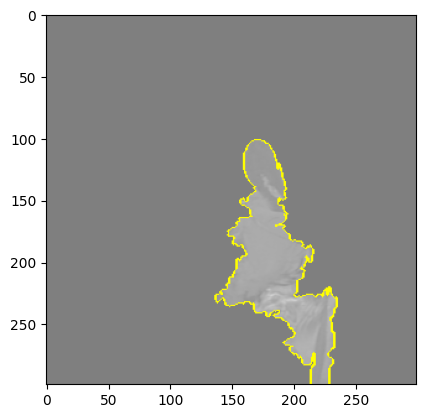

In [ ]:
#masked region of positive features only
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

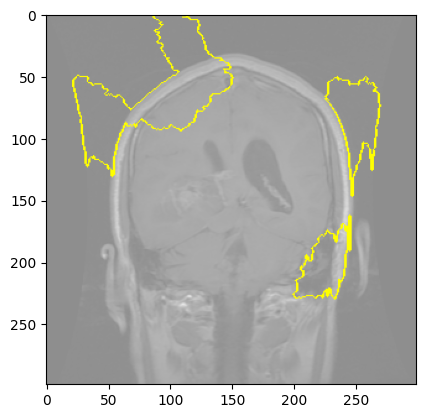

In [ ]:
#boundaries of positive regions
temp, mask = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Visualisation of Lime for both correct and incorrct prediction of Giloma image

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


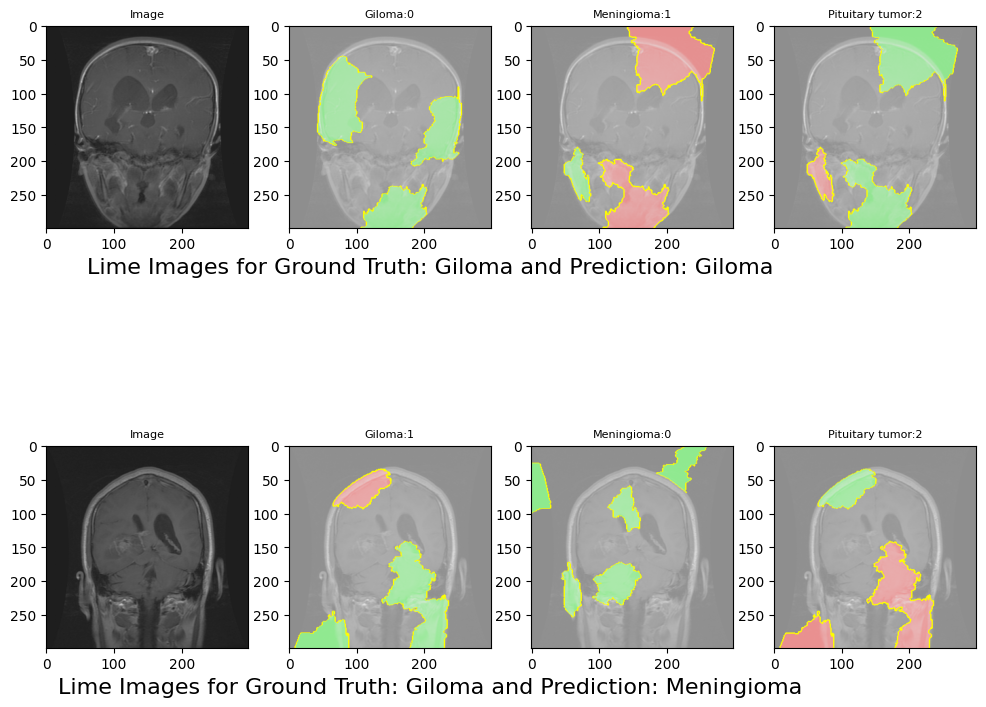

In [ ]:
#preprocessing the image
fig, ax = plt.subplots(2, 4,figsize= (12,10))
for k in range(2):
  if k==1:
    image = cv2.imread('/content/drive/MyDrive/Applied Artificial Intelligence/Glioma_original_2757.png_3ea5f5d7-9372-4721-a228-33a62ec72f04.png')
    image = cv2.resize(image, (299, 299))
    image = image.astype('float32') / 255
  else:
    image = Dic['Giloma_image'][11] 
    image = cv2.resize(image, (299, 299))
    image = image.astype('float32') / 255
  
  list_label = ['Giloma','Meningioma','Pituitary tumor']

#creating the explanation using lime
  explanation = explainer.explain_instance(image.astype('double'), loaded_model.predict, top_labels=3, hide_color=0, num_samples=1000)
  suptitle = f"Lime Images for Ground Truth: Giloma and Prediction: {list_label[explanation.top_labels[0]]}"
    
    # Set the subtitle for the first subplot
  ax[k][0].set_xlabel(suptitle, fontsize=16,x=1.9,y=0.99)
  #plotting the real Image
  ax[k][0].imshow(image)
  ax[k][0].set_title('Image',fontsize =8)

#getting the image, and lime image for each classes
  for i in range(3):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=5, hide_rest=False)
    
    ax[k][i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax[k][i+1].set_title(f'{list_label[i]}:{explanation.top_labels[i]}',fontsize = 8)
    


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


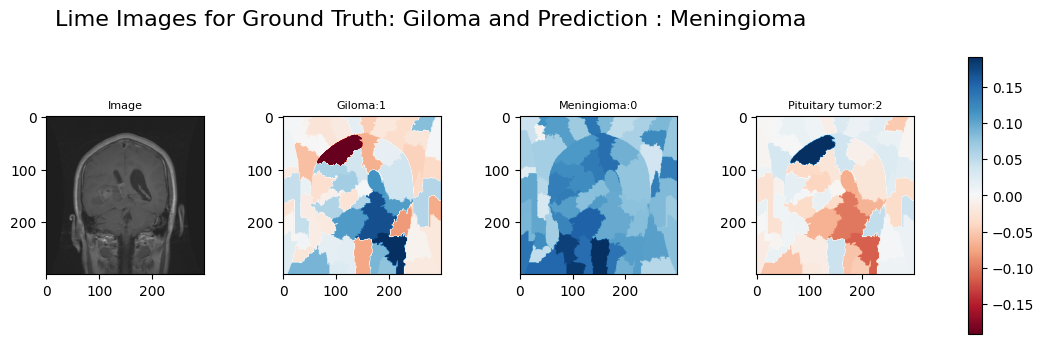

In [ ]:
#creating subplots
image = cv2.imread('/content/drive/MyDrive/Applied Artificial Intelligence/Glioma_original_2757.png_3ea5f5d7-9372-4721-a228-33a62ec72f04.png')
image = cv2.resize(image, (299, 299))
image = image.astype('float32') / 255

explanation = explainer.explain_instance(image.astype('double'), loaded_model.predict, top_labels=3, hide_color=0, num_samples=1000)

fig, ax = plt.subplots(1, 4,figsize= (14,12))
fig.suptitle(f"Lime Images for Ground Truth: Giloma and Prediction : {list_label[explanation.top_labels[0]]}", fontsize=16,y=0.65,x= 0.4)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

#plotting the real Image
ax[0].imshow(image)
ax[0].set_title('Image',fontsize = 8)

#plotting lime heatmap images (Using a variety of values in for positve and negative values)
for i in range(3):
    ind =  explanation.top_labels[i]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    im = ax[i+1].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax[i+1].set_title(f'{list_label[i]}:{explanation.top_labels[i]}',fontsize = 8)
fig.colorbar(im, ax=ax.ravel().tolist(),shrink=0.3)

## Shap